## 1. Import Library

In [1]:
# Basic Library
import pandas as pd
import numpy as np
import os

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from lightgbm import LGBMClassifier
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 2. Import Data

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")

## 3. LightGBM Modeling

### (1) HP Tuning

In [3]:
train_x = train.iloc[:, 1:-1]
train_y = train.iloc[:, -1:]
test_x = test.iloc[:, 1:]

In [5]:
def lgb_objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 91373,
        "verbosity": -1,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        'learning_rate': trial.suggest_uniform("learning_rate", 0.001, 0.01),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0.0, 1),
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0.0, 1),
        "max_depth": trial.suggest_int("max_depth", 5, 8),
        "num_leaves": trial.suggest_int("num_leaves", 200, 1200),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.4, 0.8), # feature_fraction
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 10),
        "max_bin": trial.suggest_int("max_bin", 150, 400),
    }
    
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()

        lgbmodel = LGBMClassifier(**params_lgb)
                                                                                        # 진행상황 보고싶을때 None을 100으로
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=None) 
        cv[val_idx, :] = lgbmodel.predict_proba(x_val)
        
    print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(train_y, np.argmax(cv, axis=1)))

    
    return accuracy_score(train_y, np.argmax(cv, axis=1))

In [6]:
sampler = TPESampler(seed=42)
lgb_study = optuna.create_study(study_name="lgb_parameter_opt", direction="maximize", sampler=sampler)
lgb_study.optimize(lgb_objective, n_trials=20)

lgb_best_hyperparams = lgb_study.best_trial.params
lgb_base_hyperparams = {'objective':'multiclass', 'n_estimators':10000,
                        'lambda_l1':lgb_best_hyperparams['reg_alpha'],
                        'lambda_l2':lgb_best_hyperparams['reg_lambda'],
                        'reg_alpha':None, 'reg_lambda':None
                       }
lgb_best_hyperparams.update(lgb_base_hyperparams)
print("The best hyperparameters are:\n", lgb_best_hyperparams)

[I 2022-03-14 00:21:24,944] A new study created in memory with name: lgb_parameter_opt
[I 2022-03-14 00:23:35,100] Trial 0 finished with value: 0.8295503211991435 and parameters: {'learning_rate': 0.004370861069626263, 'reg_alpha': 0.9507143064099162, 'reg_lambda': 0.7319939418114051, 'max_depth': 5, 'num_leaves': 356, 'colsample_bytree': 0.46239780813448106, 'subsample': 0.5290418060840998, 'subsample_freq': 9, 'min_child_samples': 7, 'max_bin': 327}. Best is trial 0 with value: 0.8295503211991435.


multi_logloss: 0.4787635437362814
accuracy_score: 0.8295503211991435


[I 2022-03-14 00:25:18,992] Trial 1 finished with value: 0.8008565310492506 and parameters: {'learning_rate': 0.001185260448662222, 'reg_alpha': 0.9699098521619943, 'reg_lambda': 0.8324426408004217, 'max_depth': 3, 'num_leaves': 382, 'colsample_bytree': 0.47336180394137356, 'subsample': 0.6521211214797689, 'subsample_freq': 6, 'min_child_samples': 5, 'max_bin': 223}. Best is trial 0 with value: 0.8295503211991435.


multi_logloss: 0.559027300731353
accuracy_score: 0.8008565310492506


[I 2022-03-14 00:25:59,584] Trial 2 finished with value: 0.8308351177730193 and parameters: {'learning_rate': 0.006506676052501416, 'reg_alpha': 0.13949386065204183, 'reg_lambda': 0.29214464853521815, 'max_depth': 4, 'num_leaves': 656, 'colsample_bytree': 0.7140703845572055, 'subsample': 0.5998368910791798, 'subsample_freq': 6, 'min_child_samples': 6, 'max_bin': 161}. Best is trial 2 with value: 0.8308351177730193.


multi_logloss: 0.46918888917942675
accuracy_score: 0.8308351177730193


[I 2022-03-14 00:27:23,841] Trial 3 finished with value: 0.8364025695931477 and parameters: {'learning_rate': 0.006467903667112946, 'reg_alpha': 0.17052412368729153, 'reg_lambda': 0.06505159298527952, 'max_depth': 6, 'num_leaves': 1166, 'colsample_bytree': 0.7233589392465845, 'subsample': 0.6523068845866853, 'subsample_freq': 1, 'min_child_samples': 7, 'max_bin': 260}. Best is trial 3 with value: 0.8364025695931477.


multi_logloss: 0.45542063443656805
accuracy_score: 0.8364025695931477


[I 2022-03-14 00:30:39,795] Trial 4 finished with value: 0.8389721627408994 and parameters: {'learning_rate': 0.0020983441136030096, 'reg_alpha': 0.4951769101112702, 'reg_lambda': 0.034388521115218396, 'max_depth': 6, 'num_leaves': 459, 'colsample_bytree': 0.6650089137415929, 'subsample': 0.6558555380447055, 'subsample_freq': 6, 'min_child_samples': 6, 'max_bin': 196}. Best is trial 4 with value: 0.8389721627408994.


multi_logloss: 0.46142609440135346
accuracy_score: 0.8389721627408994


[I 2022-03-14 00:32:11,243] Trial 5 finished with value: 0.8329764453961456 and parameters: {'learning_rate': 0.009726261649881027, 'reg_alpha': 0.7751328233611146, 'reg_lambda': 0.9394989415641891, 'max_depth': 6, 'num_leaves': 798, 'colsample_bytree': 0.7687496940092468, 'subsample': 0.5442462510259598, 'subsample_freq': 2, 'min_child_samples': 1, 'max_bin': 231}. Best is trial 4 with value: 0.8389721627408994.


multi_logloss: 0.4589021349488467
accuracy_score: 0.8329764453961456


[I 2022-03-14 00:33:29,503] Trial 6 finished with value: 0.8269807280513919 and parameters: {'learning_rate': 0.004498095607205339, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293, 'max_depth': 4, 'num_leaves': 481, 'colsample_bytree': 0.6170784332632995, 'subsample': 0.5704621124873813, 'subsample_freq': 9, 'min_child_samples': 1, 'max_bin': 397}. Best is trial 4 with value: 0.8389721627408994.


multi_logloss: 0.47733587674460737
accuracy_score: 0.8269807280513919


[I 2022-03-14 00:34:28,734] Trial 7 finished with value: 0.823982869379015 and parameters: {'learning_rate': 0.007950202923669918, 'reg_alpha': 0.1987156815341724, 'reg_lambda': 0.005522117123602399, 'max_depth': 6, 'num_leaves': 907, 'colsample_bytree': 0.691602867216395, 'subsample': 0.8856351733429728, 'subsample_freq': 1, 'min_child_samples': 4, 'max_bin': 179}. Best is trial 4 with value: 0.8389721627408994.


multi_logloss: 0.4702103371210295
accuracy_score: 0.823982869379015


[I 2022-03-14 00:34:57,707] Trial 8 finished with value: 0.8175588865096359 and parameters: {'learning_rate': 0.008767930832880343, 'reg_alpha': 0.6232981268275579, 'reg_lambda': 0.3308980248526492, 'max_depth': 3, 'num_leaves': 511, 'colsample_bytree': 0.5300733288106989, 'subsample': 0.864803089169032, 'subsample_freq': 7, 'min_child_samples': 9, 'max_bin': 268}. Best is trial 4 with value: 0.8389721627408994.


multi_logloss: 0.4947462312490232
accuracy_score: 0.8175588865096359


[I 2022-03-14 00:37:54,778] Trial 9 finished with value: 0.8329764453961456 and parameters: {'learning_rate': 0.0020763482134447155, 'reg_alpha': 0.713244787222995, 'reg_lambda': 0.7607850486168974, 'max_depth': 5, 'num_leaves': 971, 'colsample_bytree': 0.5975182385457564, 'subsample': 0.7613664146909971, 'subsample_freq': 5, 'min_child_samples': 1, 'max_bin': 177}. Best is trial 4 with value: 0.8389721627408994.


multi_logloss: 0.46942654599044487
accuracy_score: 0.8329764453961456


[I 2022-03-14 00:40:50,774] Trial 10 finished with value: 0.8209850107066381 and parameters: {'learning_rate': 0.0028685695745936587, 'reg_alpha': 0.4733273214546684, 'reg_lambda': 0.5180371644945151, 'max_depth': 5, 'num_leaves': 220, 'colsample_bytree': 0.6163775632702192, 'subsample': 0.9798853729727101, 'subsample_freq': 4, 'min_child_samples': 10, 'max_bin': 335}. Best is trial 4 with value: 0.8389721627408994.


multi_logloss: 0.4843046605939106
accuracy_score: 0.8209850107066381


[I 2022-03-14 00:42:02,821] Trial 11 finished with value: 0.8299785867237688 and parameters: {'learning_rate': 0.0061037371022294035, 'reg_alpha': 0.009372611862680125, 'reg_lambda': 0.023479446678145548, 'max_depth': 6, 'num_leaves': 1194, 'colsample_bytree': 0.7758524559654705, 'subsample': 0.7029095352074474, 'subsample_freq': 3, 'min_child_samples': 8, 'max_bin': 238}. Best is trial 4 with value: 0.8389721627408994.


multi_logloss: 0.459575625196517
accuracy_score: 0.8299785867237688


[I 2022-03-14 00:44:26,055] Trial 12 finished with value: 0.8334047109207708 and parameters: {'learning_rate': 0.003989793809299156, 'reg_alpha': 0.3882740411333113, 'reg_lambda': 0.22944928275879212, 'max_depth': 6, 'num_leaves': 1182, 'colsample_bytree': 0.6891499127306165, 'subsample': 0.7585006738258345, 'subsample_freq': 8, 'min_child_samples': 4, 'max_bin': 295}. Best is trial 4 with value: 0.8389721627408994.


multi_logloss: 0.4657367415644784
accuracy_score: 0.8334047109207708


[I 2022-03-14 00:45:22,015] Trial 13 finished with value: 0.8364025695931477 and parameters: {'learning_rate': 0.007578201720730746, 'reg_alpha': 0.3581052907290342, 'reg_lambda': 0.13894664888665187, 'max_depth': 6, 'num_leaves': 697, 'colsample_bytree': 0.6578694741072342, 'subsample': 0.6593014605528402, 'subsample_freq': 4, 'min_child_samples': 7, 'max_bin': 202}. Best is trial 4 with value: 0.8389721627408994.


multi_logloss: 0.4581749022725359
accuracy_score: 0.8364025695931477


[I 2022-03-14 00:46:53,543] Trial 14 finished with value: 0.8342612419700214 and parameters: {'learning_rate': 0.005698146019573205, 'reg_alpha': 0.5760950425838212, 'reg_lambda': 0.47217385846560045, 'max_depth': 5, 'num_leaves': 1026, 'colsample_bytree': 0.7425297333566302, 'subsample': 0.8138634813435379, 'subsample_freq': 1, 'min_child_samples': 3, 'max_bin': 262}. Best is trial 4 with value: 0.8389721627408994.


multi_logloss: 0.4657373334521292
accuracy_score: 0.8342612419700214


[I 2022-03-14 00:49:01,724] Trial 15 finished with value: 0.8325481798715203 and parameters: {'learning_rate': 0.003057941273636994, 'reg_alpha': 0.12228641924355366, 'reg_lambda': 0.14158424165235112, 'max_depth': 6, 'num_leaves': 580, 'colsample_bytree': 0.5546444571791694, 'subsample': 0.6361538424790338, 'subsample_freq': 10, 'min_child_samples': 6, 'max_bin': 294}. Best is trial 4 with value: 0.8389721627408994.


multi_logloss: 0.46854247247766106
accuracy_score: 0.8325481798715203


[I 2022-03-14 00:49:37,907] Trial 16 finished with value: 0.8244111349036403 and parameters: {'learning_rate': 0.006914307738948052, 'reg_alpha': 0.027219026391196888, 'reg_lambda': 0.4520416659181694, 'max_depth': 4, 'num_leaves': 809, 'colsample_bytree': 0.409478164602333, 'subsample': 0.7040595702019269, 'subsample_freq': 3, 'min_child_samples': 8, 'max_bin': 205}. Best is trial 4 with value: 0.8389721627408994.


multi_logloss: 0.4748324574227684
accuracy_score: 0.8244111349036403


[I 2022-03-14 00:50:57,396] Trial 17 finished with value: 0.8325481798715203 and parameters: {'learning_rate': 0.0053479409918422895, 'reg_alpha': 0.43993787934342365, 'reg_lambda': 0.1254444231666659, 'max_depth': 5, 'num_leaves': 296, 'colsample_bytree': 0.6373144665009226, 'subsample': 0.511019367957251, 'subsample_freq': 7, 'min_child_samples': 5, 'max_bin': 351}. Best is trial 4 with value: 0.8389721627408994.


multi_logloss: 0.4645463981053878
accuracy_score: 0.8325481798715203


[I 2022-03-14 00:56:41,797] Trial 18 finished with value: 0.8304068522483941 and parameters: {'learning_rate': 0.0012297853395221475, 'reg_alpha': 0.27340199043500024, 'reg_lambda': 0.579665873013364, 'max_depth': 6, 'num_leaves': 1059, 'colsample_bytree': 0.7275837236985672, 'subsample': 0.7030354668181216, 'subsample_freq': 5, 'min_child_samples': 7, 'max_bin': 247}. Best is trial 4 with value: 0.8389721627408994.


multi_logloss: 0.46476836659355075
accuracy_score: 0.8304068522483941


[I 2022-03-14 00:57:42,811] Trial 19 finished with value: 0.8325481798715203 and parameters: {'learning_rate': 0.00499726017408217, 'reg_alpha': 0.7703792522166535, 'reg_lambda': 0.3652732180365787, 'max_depth': 5, 'num_leaves': 832, 'colsample_bytree': 0.7913003854203549, 'subsample': 0.5883019650024282, 'subsample_freq': 3, 'min_child_samples': 10, 'max_bin': 150}. Best is trial 4 with value: 0.8389721627408994.


multi_logloss: 0.4658750940402883
accuracy_score: 0.8325481798715203
The best hyperparameters are:
 {'learning_rate': 0.0020983441136030096, 'reg_alpha': None, 'reg_lambda': None, 'max_depth': 6, 'num_leaves': 459, 'colsample_bytree': 0.6650089137415929, 'subsample': 0.6558555380447055, 'subsample_freq': 6, 'min_child_samples': 6, 'max_bin': 196, 'objective': 'multiclass', 'n_estimators': 10000, 'lambda_l1': 0.4951769101112702, 'lambda_l2': 0.034388521115218396}


/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_58172/2686553518.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(lgb_study);


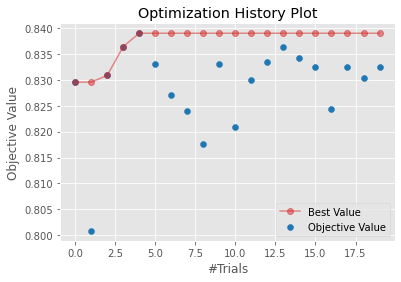

In [7]:
optuna.visualization.matplotlib.plot_optimization_history(lgb_study);

/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_58172/3200258722.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(lgb_study);


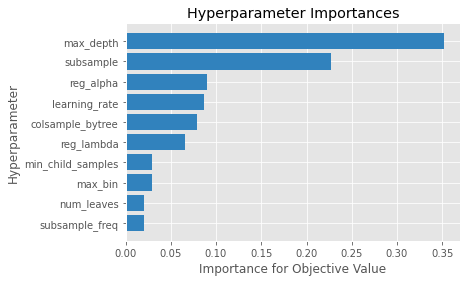

In [8]:
optuna.visualization.matplotlib.plot_param_importances(lgb_study);

/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_58172/1653781200.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(lgb_study);


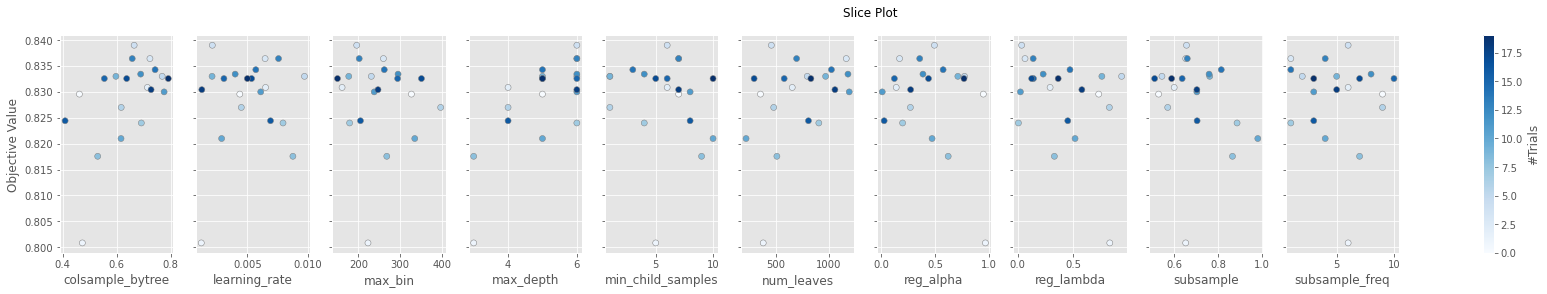

In [9]:
optuna.visualization.matplotlib.plot_slice(lgb_study);

### (2) Training

In [10]:
lgb_acc = []
lgb_pred = np.zeros((test_x.shape[0], 4))
seed = 42
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for n, (train_idx, val_idx) in enumerate(skf.split(train_x, train_y)):
    print(f"{n+1} Fold Training.....")
    x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
    y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()
    
    lgbmodel = LGBMClassifier(**lgb_best_hyperparams)
    lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=None)

    val_pred = lgbmodel.predict_proba(x_val)
    val_cls = np.argmax(val_pred, axis=1)
    
    fold_lgb_acc = accuracy_score(y_val, val_cls)
    lgb_acc.append(fold_lgb_acc)
    
    print(f'fold{n+1} score: {fold_lgb_acc}')
    fold_pred = lgbmodel.predict_proba(test_x) / skf.n_splits
    lgb_pred += fold_pred

1 Fold Training.....
fold1 score: 0.8222698072805139
2 Fold Training.....
fold2 score: 0.8586723768736617
3 Fold Training.....
fold3 score: 0.8222698072805139
4 Fold Training.....
fold4 score: 0.8244111349036403
5 Fold Training.....
fold5 score: 0.841541755888651


In [11]:
np.mean(lgb_acc)

0.8338329764453961

## 4. CNN Modeling

### (1) HP Tuning

In [12]:
train_x = train.iloc[:, 1:-1]
test_x = test.iloc[:, 1:]

train_x = np.array(train_x).reshape(-1, 8, 4, 1)
test_x = np.array(test_x).reshape(-1, 8, 4, 1)

ohe = OneHotEncoder(sparse = False)
train_y = ohe.fit_transform(train[['target']])

In [ ]:
def create_model(mid_units, num_filters, dropout_rate):
    
    model = Sequential()
    model.add(Conv2D(filters=num_filters[0], kernel_size=(2, 2),
                 activation="elu",
                 input_shape=(8, 4, 1)))
    model.add(BatchNormalization())
    #model.add(Dropout(dropout_rate[0]))
    for i in range(1,num_layer):
        model.add(Conv2D(filters=num_filters[i], kernel_size=(2, 2), padding="same", activation="elu"))
        model.add(BatchNormalization())
        #model.add(Dropout(dropout_rate[i+1]))
            
    model.add(GlobalAveragePooling2D())
    model.add(Dense(mid_units, activation='relu'))
    #model.add(Dropout(dropout_rate[-1]))
    model.add(Dense(4, activation='softmax'))
    
    return model

In [43]:
def cnn_objective(trial: Trial) -> float:
    
    #clear_session
    keras.backend.clear_session()
    
    #number of the convolution layer
    #num_layer = trial.suggest_int("num_layer", 2, 3)
    
    #number of the unit
    mid_units = int(trial.suggest_discrete_uniform("mid_units", 16, 128, 16))
    
    #number of the each convolution layer filter
#     num_filters = [int(trial.suggest_discrete_uniform("num_filter_0", 8, 64, 8)),
#                   int(trial.suggest_discrete_uniform("num_filter_1", 16, 128, 16)),
#                   int(trial.suggest_discrete_uniform("num_filter_2", 16, 256, 16))]
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]

    #Dropout
    #dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    dropout_rate = [int(trial.suggest_uniform("dropout_rate"+str(ii), 0.0, 0.5)) for ii in range(num_layer+1)]
    
    
        
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train.target)):

        x_train, y_train = train_x[train_idx], train_y[train_idx]
        x_val, y_val = train_x[val_idx], train_y[val_idx]
        
        mc = ModelCheckpoint(f"model/model_{n+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
        
        model = create_model(num_layer, mid_units, num_filters, dropout_rate)
        
        # Adam optimizer learning rate
        optimizer = Adam(learning_rate=trial.suggest_uniform("learning_rate", 1e-4, 1e-2))
        model.compile(optimizer=optimizer,
                      loss="categorical_crossentropy",
                      metrics=["acc"])
        model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, 
                  callbacks=[es,mc], verbose=None)
        
        best = load_model(f"model/model_{n+1}.h5")
        
        cv[val_idx, :] = best.predict(x_val)
        
    print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1)))

    
    return accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1))

In [44]:
## sampler = TPESampler(seed=42)
cnn_study = optuna.create_study(study_name="cnn_parameter_opt", direction="maximize", sampler=sampler)
cnn_study.optimize(cnn_objective, n_trials=50)

[I 2022-03-14 02:22:29,423] A new study created in memory with name: cnn_parameter_opt
[I 2022-03-14 02:23:17,670] Trial 0 finished with value: 0.8552462526766595 and parameters: {'num_layer': 3, 'mid_units': 112.0, 'num_filter_0': 64.0, 'num_filter_1': 32.0, 'num_filter_2': 80.0, 'dropout_rate0': 0.08061064362700221, 'dropout_rate1': 0.46484882617128653, 'dropout_rate2': 0.4040601897822085, 'dropout_rate3': 0.31670187825521173, 'learning_rate': 0.008727459842858406}. Best is trial 0 with value: 0.8552462526766595.


multi_logloss: 0.46669803470486476
accuracy_score: 0.8552462526766595


[I 2022-03-14 02:26:26,695] Trial 1 finished with value: 0.8475374732334047 and parameters: {'num_layer': 4, 'mid_units': 32.0, 'num_filter_0': 240.0, 'num_filter_1': 144.0, 'num_filter_2': 208.0, 'num_filter_3': 240.0, 'dropout_rate0': 0.15900173748593194, 'dropout_rate1': 0.05502596226383838, 'dropout_rate2': 0.11396758127097084, 'dropout_rate3': 0.21355389431312816, 'dropout_rate4': 0.40900738296124656, 'learning_rate': 0.0086212327742378}. Best is trial 0 with value: 0.8552462526766595.


multi_logloss: 0.48520943405652817
accuracy_score: 0.8475374732334047


[I 2022-03-14 02:27:10,854] Trial 2 finished with value: 0.8736616702355461 and parameters: {'num_layer': 2, 'mid_units': 80.0, 'num_filter_0': 112.0, 'num_filter_1': 64.0, 'dropout_rate0': 0.0599326836668414, 'dropout_rate1': 0.16880758570181398, 'dropout_rate2': 0.4714548519562596, 'learning_rate': 0.003299709027005477}. Best is trial 2 with value: 0.8736616702355461.


multi_logloss: 0.38009025582075745
accuracy_score: 0.8736616702355461


[I 2022-03-14 02:30:54,439] Trial 3 finished with value: 0.8775160599571734 and parameters: {'num_layer': 3, 'mid_units': 96.0, 'num_filter_0': 96.0, 'num_filter_1': 256.0, 'num_filter_2': 256.0, 'dropout_rate0': 0.12589114791268208, 'dropout_rate1': 0.24862425294619273, 'dropout_rate2': 0.15043915490838483, 'dropout_rate3': 0.1424202471887338, 'learning_rate': 0.0004651807788098747}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.3759628614438479
accuracy_score: 0.8775160599571734


[I 2022-03-14 02:31:54,357] Trial 4 finished with value: 0.8599571734475375 and parameters: {'num_layer': 3, 'mid_units': 80.0, 'num_filter_0': 16.0, 'num_filter_1': 80.0, 'num_filter_2': 240.0, 'dropout_rate0': 0.11978094533348621, 'dropout_rate1': 0.07244743604561155, 'dropout_rate2': 0.2447263801387815, 'dropout_rate3': 0.49282522705530035, 'learning_rate': 0.002496347187963854}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.4068602490127379
accuracy_score: 0.8599571734475375


[I 2022-03-14 02:33:27,538] Trial 5 finished with value: 0.8522483940042827 and parameters: {'num_layer': 4, 'mid_units': 112.0, 'num_filter_0': 64.0, 'num_filter_1': 192.0, 'num_filter_2': 96.0, 'num_filter_3': 176.0, 'dropout_rate0': 0.31676485538044735, 'dropout_rate1': 0.26788734203737924, 'dropout_rate2': 0.04514488502720415, 'dropout_rate3': 0.417651247794619, 'dropout_rate4': 0.16039003248586792, 'learning_rate': 0.0019465332529585572}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.43225209535250625
accuracy_score: 0.8522483940042827


[I 2022-03-14 02:34:12,002] Trial 6 finished with value: 0.8706638115631692 and parameters: {'num_layer': 2, 'mid_units': 80.0, 'num_filter_0': 176.0, 'num_filter_1': 16.0, 'dropout_rate0': 0.2560465291496405, 'dropout_rate1': 0.11324788759896898, 'dropout_rate2': 0.32258639520472493, 'learning_rate': 0.0018262276471494154}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.38736140969791333
accuracy_score: 0.8706638115631692


[I 2022-03-14 02:35:46,034] Trial 7 finished with value: 0.8535331905781585 and parameters: {'num_layer': 4, 'mid_units': 64.0, 'num_filter_0': 240.0, 'num_filter_1': 48.0, 'num_filter_2': 96.0, 'num_filter_3': 32.0, 'dropout_rate0': 0.4623468091392814, 'dropout_rate1': 0.4386696766904905, 'dropout_rate2': 0.1289708138575778, 'dropout_rate3': 0.3299920230170895, 'dropout_rate4': 0.4086111001006079, 'learning_rate': 0.005596488034834678}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.41485872841489074
accuracy_score: 0.8535331905781585


[I 2022-03-14 02:37:24,609] Trial 8 finished with value: 0.8582441113490364 and parameters: {'num_layer': 3, 'mid_units': 32.0, 'num_filter_0': 32.0, 'num_filter_1': 240.0, 'num_filter_2': 240.0, 'dropout_rate0': 0.31655072863663397, 'dropout_rate1': 0.16951489552435034, 'dropout_rate2': 0.17460478730633044, 'dropout_rate3': 0.3629778394351197, 'learning_rate': 0.008981391573530513}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.417837693603039
accuracy_score: 0.8582441113490364


[I 2022-03-14 02:38:35,901] Trial 9 finished with value: 0.8595289079229123 and parameters: {'num_layer': 4, 'mid_units': 112.0, 'num_filter_0': 176.0, 'num_filter_1': 32.0, 'num_filter_2': 48.0, 'num_filter_3': 240.0, 'dropout_rate0': 0.30321452982979497, 'dropout_rate1': 0.004598525808314824, 'dropout_rate2': 0.05073577143301605, 'dropout_rate3': 0.3317508845540279, 'dropout_rate4': 0.0025307919231093434, 'learning_rate': 0.0016919997090332369}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.41078073726704256
accuracy_score: 0.8595289079229123


[I 2022-03-14 02:39:44,923] Trial 10 finished with value: 0.862526766595289 and parameters: {'num_layer': 2, 'mid_units': 128.0, 'num_filter_0': 128.0, 'num_filter_1': 256.0, 'dropout_rate0': 0.18486226631303898, 'dropout_rate1': 0.33401776461187416, 'dropout_rate2': 0.23889861393810988, 'learning_rate': 0.005012280029187345}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.42505010013580724
accuracy_score: 0.862526766595289


[I 2022-03-14 02:41:53,398] Trial 11 finished with value: 0.8531049250535332 and parameters: {'num_layer': 2, 'mid_units': 64.0, 'num_filter_0': 112.0, 'num_filter_1': 112.0, 'dropout_rate0': 0.03923119248339024, 'dropout_rate1': 0.2282716783254814, 'dropout_rate2': 0.4996812193207758, 'learning_rate': 0.0001298280687264339}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.423228580858127
accuracy_score: 0.8531049250535332


[I 2022-03-14 02:42:54,433] Trial 12 finished with value: 0.8633832976445396 and parameters: {'num_layer': 2, 'mid_units': 96.0, 'num_filter_0': 96.0, 'num_filter_1': 176.0, 'dropout_rate0': 0.006570157858904191, 'dropout_rate1': 0.3340933828874896, 'dropout_rate2': 0.3604079078790515, 'learning_rate': 0.004218711522482238}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.4006351527297266
accuracy_score: 0.8633832976445396


[I 2022-03-14 02:45:13,503] Trial 13 finished with value: 0.8676659528907923 and parameters: {'num_layer': 3, 'mid_units': 48.0, 'num_filter_0': 160.0, 'num_filter_1': 96.0, 'num_filter_2': 160.0, 'dropout_rate0': 0.1938592999537082, 'dropout_rate1': 0.20285603754156398, 'dropout_rate2': 0.484634926024359, 'dropout_rate3': 0.03497014642003313, 'learning_rate': 0.00020022480338332876}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.3792141819396945
accuracy_score: 0.8676659528907923


[I 2022-03-14 02:46:04,444] Trial 14 finished with value: 0.8680942184154176 and parameters: {'num_layer': 2, 'mid_units': 96.0, 'num_filter_0': 80.0, 'num_filter_1': 160.0, 'dropout_rate0': 0.08918776999743644, 'dropout_rate1': 0.2952178843288601, 'dropout_rate2': 0.0007698231287480706, 'learning_rate': 0.003407321847453953}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.40483048595932186
accuracy_score: 0.8680942184154176


[I 2022-03-14 02:48:15,442] Trial 15 finished with value: 0.8633832976445396 and parameters: {'num_layer': 3, 'mid_units': 96.0, 'num_filter_0': 144.0, 'num_filter_1': 208.0, 'num_filter_2': 176.0, 'dropout_rate0': 0.0036082562470229063, 'dropout_rate1': 0.1493545375242981, 'dropout_rate2': 0.29563848084470523, 'dropout_rate3': 0.12305979782048834, 'learning_rate': 0.0066220183275408715}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.4730533579811859
accuracy_score: 0.8633832976445396


[I 2022-03-14 02:49:15,299] Trial 16 finished with value: 0.8616702355460385 and parameters: {'num_layer': 2, 'mid_units': 16.0, 'num_filter_0': 192.0, 'num_filter_1': 64.0, 'dropout_rate0': 0.1308271202551839, 'dropout_rate1': 0.3979338809467864, 'dropout_rate2': 0.42285651327199825, 'learning_rate': 0.006623747253401386}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.403535937456975
accuracy_score: 0.8616702355460385


[I 2022-03-14 02:50:48,892] Trial 17 finished with value: 0.8715203426124197 and parameters: {'num_layer': 3, 'mid_units': 128.0, 'num_filter_0': 48.0, 'num_filter_1': 128.0, 'num_filter_2': 256.0, 'dropout_rate0': 0.41898961315815747, 'dropout_rate1': 0.20777636528167936, 'dropout_rate2': 0.18790896854036404, 'dropout_rate3': 0.15051524666263352, 'learning_rate': 0.003312834159040878}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.40744248508062414
accuracy_score: 0.8715203426124197


[I 2022-03-14 02:52:06,568] Trial 18 finished with value: 0.8706638115631692 and parameters: {'num_layer': 2, 'mid_units': 80.0, 'num_filter_0': 112.0, 'num_filter_1': 224.0, 'dropout_rate0': 0.23096983980244185, 'dropout_rate1': 0.13680177734956714, 'dropout_rate2': 0.1730658962186914, 'learning_rate': 0.0012280573813085581}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.3724334969658209
accuracy_score: 0.8706638115631692


[I 2022-03-14 02:53:51,664] Trial 19 finished with value: 0.8668094218415417 and parameters: {'num_layer': 3, 'mid_units': 48.0, 'num_filter_0': 208.0, 'num_filter_1': 96.0, 'num_filter_2': 192.0, 'dropout_rate0': 0.06610034759158546, 'dropout_rate1': 0.3659584713914405, 'dropout_rate2': 0.28505677232301696, 'dropout_rate3': 0.02226692414380893, 'learning_rate': 0.0034015217090420115}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.3992947855480368
accuracy_score: 0.8668094218415417


[I 2022-03-14 02:54:58,744] Trial 20 finished with value: 0.8569593147751606 and parameters: {'num_layer': 4, 'mid_units': 64.0, 'num_filter_0': 96.0, 'num_filter_1': 144.0, 'num_filter_2': 16.0, 'num_filter_3': 16.0, 'dropout_rate0': 0.125199016010008, 'dropout_rate1': 0.27102070998823424, 'dropout_rate2': 0.395986035960489, 'dropout_rate3': 0.20730409487559354, 'dropout_rate4': 0.2327122497128112, 'learning_rate': 0.009974951301961639}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.42341547314993044
accuracy_score: 0.8569593147751606


[I 2022-03-14 02:56:32,113] Trial 21 finished with value: 0.8663811563169165 and parameters: {'num_layer': 3, 'mid_units': 128.0, 'num_filter_0': 48.0, 'num_filter_1': 128.0, 'num_filter_2': 256.0, 'dropout_rate0': 0.45825654584736597, 'dropout_rate1': 0.20560848641454943, 'dropout_rate2': 0.20729587829746873, 'dropout_rate3': 0.15805684706695616, 'learning_rate': 0.003100720891430376}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.43191772688815067
accuracy_score: 0.8663811563169165


[I 2022-03-14 02:57:59,857] Trial 22 finished with value: 0.860813704496788 and parameters: {'num_layer': 3, 'mid_units': 128.0, 'num_filter_0': 48.0, 'num_filter_1': 112.0, 'num_filter_2': 224.0, 'dropout_rate0': 0.4237399641710969, 'dropout_rate1': 0.17918382040773362, 'dropout_rate2': 0.13490094227070648, 'dropout_rate3': 0.10268567886268502, 'learning_rate': 0.004345862053074193}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.4379481613836437
accuracy_score: 0.860813704496788


[I 2022-03-14 02:59:11,766] Trial 23 finished with value: 0.8740899357601714 and parameters: {'num_layer': 3, 'mid_units': 96.0, 'num_filter_0': 80.0, 'num_filter_1': 64.0, 'num_filter_2': 144.0, 'dropout_rate0': 0.38305083762507086, 'dropout_rate1': 0.24199278578020023, 'dropout_rate2': 0.09270809843379649, 'dropout_rate3': 0.24663264421355996, 'learning_rate': 0.0010472203579084496}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.375532412581622
accuracy_score: 0.8740899357601714


[I 2022-03-14 03:00:18,469] Trial 24 finished with value: 0.8736616702355461 and parameters: {'num_layer': 2, 'mid_units': 96.0, 'num_filter_0': 128.0, 'num_filter_1': 64.0, 'dropout_rate0': 0.2647304815996748, 'dropout_rate1': 0.24689766216974077, 'dropout_rate2': 0.08208961936358862, 'learning_rate': 0.0009203524683958748}. Best is trial 3 with value: 0.8775160599571734.


multi_logloss: 0.3588756852624487
accuracy_score: 0.8736616702355461


[I 2022-03-14 03:01:32,147] Trial 25 finished with value: 0.8788008565310492 and parameters: {'num_layer': 3, 'mid_units': 96.0, 'num_filter_0': 144.0, 'num_filter_1': 64.0, 'num_filter_2': 144.0, 'dropout_rate0': 0.34628781819050325, 'dropout_rate1': 0.308343590125591, 'dropout_rate2': 0.08629826233437901, 'dropout_rate3': 0.23099535529245624, 'learning_rate': 0.0009481280550349681}. Best is trial 25 with value: 0.8788008565310492.


multi_logloss: 0.36479795572323065
accuracy_score: 0.8788008565310492


[I 2022-03-14 03:02:42,370] Trial 26 finished with value: 0.8749464668094219 and parameters: {'num_layer': 3, 'mid_units': 112.0, 'num_filter_0': 80.0, 'num_filter_1': 16.0, 'num_filter_2': 144.0, 'dropout_rate0': 0.3764632327901125, 'dropout_rate1': 0.32386523909540577, 'dropout_rate2': 0.08855430635447373, 'dropout_rate3': 0.24997563533430556, 'learning_rate': 0.0006238257072677771}. Best is trial 25 with value: 0.8788008565310492.


multi_logloss: 0.36322528307115454
accuracy_score: 0.8749464668094219


[I 2022-03-14 03:03:46,712] Trial 27 finished with value: 0.8702355460385439 and parameters: {'num_layer': 3, 'mid_units': 112.0, 'num_filter_0': 144.0, 'num_filter_1': 16.0, 'num_filter_2': 128.0, 'dropout_rate0': 0.36342693880736787, 'dropout_rate1': 0.3132200977382283, 'dropout_rate2': 0.04481826062558451, 'dropout_rate3': 0.2722594859282068, 'learning_rate': 0.0005279704199363316}. Best is trial 25 with value: 0.8788008565310492.


multi_logloss: 0.37928991179808336
accuracy_score: 0.8702355460385439


[I 2022-03-14 03:04:24,684] Trial 28 finished with value: 0.8655246252676659 and parameters: {'num_layer': 3, 'mid_units': 112.0, 'num_filter_0': 80.0, 'num_filter_1': 32.0, 'num_filter_2': 112.0, 'dropout_rate0': 0.36277058497179965, 'dropout_rate1': 0.3752087279975303, 'dropout_rate2': 0.012678299219713418, 'dropout_rate3': 0.19942219950182247, 'learning_rate': 0.0024858453633885723}. Best is trial 25 with value: 0.8788008565310492.


multi_logloss: 0.3884907018310592
accuracy_score: 0.8655246252676659


[I 2022-03-14 03:05:35,516] Trial 29 finished with value: 0.8843683083511777 and parameters: {'num_layer': 3, 'mid_units': 112.0, 'num_filter_0': 160.0, 'num_filter_1': 16.0, 'num_filter_2': 176.0, 'dropout_rate0': 0.39676685105222653, 'dropout_rate1': 0.465946308365782, 'dropout_rate2': 0.14435313492491197, 'dropout_rate3': 0.07275611567529669, 'learning_rate': 0.0012580904276117198}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.35057712466670093
accuracy_score: 0.8843683083511777


[I 2022-03-14 03:07:16,467] Trial 30 finished with value: 0.859100642398287 and parameters: {'num_layer': 4, 'mid_units': 96.0, 'num_filter_0': 208.0, 'num_filter_1': 48.0, 'num_filter_2': 176.0, 'num_filter_3': 96.0, 'dropout_rate0': 0.28964532390820646, 'dropout_rate1': 0.41002119730227843, 'dropout_rate2': 0.1391057332375214, 'dropout_rate3': 0.004896408464022367, 'dropout_rate4': 0.4988668361058337, 'learning_rate': 0.0023345116350226946}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.455641441449133
accuracy_score: 0.859100642398287


[I 2022-03-14 03:08:17,542] Trial 31 finished with value: 0.8728051391862955 and parameters: {'num_layer': 3, 'mid_units': 112.0, 'num_filter_0': 160.0, 'num_filter_1': 16.0, 'num_filter_2': 144.0, 'dropout_rate0': 0.4959782326816241, 'dropout_rate1': 0.49029345760268206, 'dropout_rate2': 0.08258264802619344, 'dropout_rate3': 0.06645320163188101, 'learning_rate': 0.0013600016603295558}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.37423310126425574
accuracy_score: 0.8728051391862955


[I 2022-03-14 03:09:34,728] Trial 32 finished with value: 0.8753747323340471 and parameters: {'num_layer': 3, 'mid_units': 112.0, 'num_filter_0': 160.0, 'num_filter_1': 48.0, 'num_filter_2': 128.0, 'dropout_rate0': 0.3462130655506081, 'dropout_rate1': 0.456410814738769, 'dropout_rate2': 0.1583039257850809, 'dropout_rate3': 0.07193185045414754, 'learning_rate': 0.0008694028753307917}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.3616681852754904
accuracy_score: 0.8753747323340471


[I 2022-03-14 03:11:46,901] Trial 33 finished with value: 0.8642398286937901 and parameters: {'num_layer': 3, 'mid_units': 96.0, 'num_filter_0': 160.0, 'num_filter_1': 48.0, 'num_filter_2': 192.0, 'dropout_rate0': 0.4059578259277907, 'dropout_rate1': 0.49966925947496477, 'dropout_rate2': 0.16214793573240016, 'dropout_rate3': 0.0817799991124363, 'learning_rate': 0.00011406314739406003}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.3929305923933438
accuracy_score: 0.8642398286937901


[I 2022-03-14 03:13:19,258] Trial 34 finished with value: 0.8749464668094219 and parameters: {'num_layer': 3, 'mid_units': 112.0, 'num_filter_0': 192.0, 'num_filter_1': 80.0, 'num_filter_2': 112.0, 'dropout_rate0': 0.34782962739002576, 'dropout_rate1': 0.4521760880507831, 'dropout_rate2': 0.2134183571113038, 'dropout_rate3': 0.1562168730444421, 'learning_rate': 0.0013568723964531805}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.3835741104035067
accuracy_score: 0.8749464668094219


[I 2022-03-14 03:14:19,366] Trial 35 finished with value: 0.8706638115631692 and parameters: {'num_layer': 3, 'mid_units': 80.0, 'num_filter_0': 144.0, 'num_filter_1': 32.0, 'num_filter_2': 64.0, 'dropout_rate0': 0.2249842598063294, 'dropout_rate1': 0.42543198263468807, 'dropout_rate2': 0.10945779922237178, 'dropout_rate3': 0.0513967529454023, 'learning_rate': 0.002118323810637334}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.3724740328529897
accuracy_score: 0.8706638115631692


[I 2022-03-14 03:15:48,317] Trial 36 finished with value: 0.859100642398287 and parameters: {'num_layer': 3, 'mid_units': 128.0, 'num_filter_0': 224.0, 'num_filter_1': 80.0, 'num_filter_2': 128.0, 'dropout_rate0': 0.32389718748505614, 'dropout_rate1': 0.3722260299486016, 'dropout_rate2': 0.21212320189067266, 'dropout_rate3': 0.11954938327962948, 'learning_rate': 0.0028509271870895804}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.42419813100919335
accuracy_score: 0.859100642398287


[I 2022-03-14 03:18:53,094] Trial 37 finished with value: 0.8676659528907923 and parameters: {'num_layer': 4, 'mid_units': 112.0, 'num_filter_0': 176.0, 'num_filter_1': 192.0, 'num_filter_2': 160.0, 'num_filter_3': 128.0, 'dropout_rate0': 0.3392250984454246, 'dropout_rate1': 0.4642313574844164, 'dropout_rate2': 0.15075387645186422, 'dropout_rate3': 0.085977282859064, 'dropout_rate4': 0.007400315321265699, 'learning_rate': 0.0008548792168492957}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.3978284039145996
accuracy_score: 0.8676659528907923


[I 2022-03-14 03:20:40,590] Trial 38 finished with value: 0.867237687366167 and parameters: {'num_layer': 3, 'mid_units': 96.0, 'num_filter_0': 256.0, 'num_filter_1': 48.0, 'num_filter_2': 208.0, 'dropout_rate0': 0.28014318899600216, 'dropout_rate1': 0.47605547958562494, 'dropout_rate2': 0.05788070171677247, 'dropout_rate3': 0.13963373874067542, 'learning_rate': 0.0018817129276999913}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.4097450961356486
accuracy_score: 0.867237687366167


[I 2022-03-14 03:21:31,706] Trial 39 finished with value: 0.8749464668094219 and parameters: {'num_layer': 3, 'mid_units': 80.0, 'num_filter_0': 112.0, 'num_filter_1': 32.0, 'num_filter_2': 80.0, 'dropout_rate0': 0.40248054368745156, 'dropout_rate1': 0.09620952490817192, 'dropout_rate2': 0.2664168860039607, 'dropout_rate3': 0.18627465177219116, 'learning_rate': 0.0015662763785685746}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.36915627018392927
accuracy_score: 0.8749464668094219


[I 2022-03-14 03:24:28,238] Trial 40 finished with value: 0.8488222698072805 and parameters: {'num_layer': 4, 'mid_units': 80.0, 'num_filter_0': 128.0, 'num_filter_1': 256.0, 'num_filter_2': 160.0, 'num_filter_3': 176.0, 'dropout_rate0': 0.4633110504904528, 'dropout_rate1': 0.27682020607768787, 'dropout_rate2': 0.10604328897526788, 'dropout_rate3': 0.09857400865444757, 'dropout_rate4': 0.11810000818453636, 'learning_rate': 0.003926514016822976}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.4953358693972792
accuracy_score: 0.8488222698072805


[I 2022-03-14 03:25:57,779] Trial 41 finished with value: 0.8749464668094219 and parameters: {'num_layer': 3, 'mid_units': 112.0, 'num_filter_0': 192.0, 'num_filter_1': 80.0, 'num_filter_2': 112.0, 'dropout_rate0': 0.3441201279596384, 'dropout_rate1': 0.4358607510907861, 'dropout_rate2': 0.21548972456625826, 'dropout_rate3': 0.17073679427578892, 'learning_rate': 0.0013685401156366388}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.37572447513080737
accuracy_score: 0.8749464668094219


[I 2022-03-14 03:27:35,822] Trial 42 finished with value: 0.8710920770877945 and parameters: {'num_layer': 3, 'mid_units': 112.0, 'num_filter_0': 192.0, 'num_filter_1': 80.0, 'num_filter_2': 112.0, 'dropout_rate0': 0.3399408162847834, 'dropout_rate1': 0.44230673925183017, 'dropout_rate2': 0.18682221025851942, 'dropout_rate3': 0.17939556111869553, 'learning_rate': 0.0006242536909556243}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.3896668491459669
accuracy_score: 0.8710920770877945


[I 2022-03-14 03:28:24,004] Trial 43 finished with value: 0.8732334047109208 and parameters: {'num_layer': 3, 'mid_units': 80.0, 'num_filter_0': 96.0, 'num_filter_1': 32.0, 'num_filter_2': 64.0, 'dropout_rate0': 0.4144878728077641, 'dropout_rate1': 0.06941539197942176, 'dropout_rate2': 0.26307545406043115, 'dropout_rate3': 0.28753691033812906, 'learning_rate': 0.0017213833243145517}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.3700839241738731
accuracy_score: 0.8732334047109208


[I 2022-03-14 03:29:38,359] Trial 44 finished with value: 0.8659528907922912 and parameters: {'num_layer': 3, 'mid_units': 128.0, 'num_filter_0': 176.0, 'num_filter_1': 96.0, 'num_filter_2': 128.0, 'dropout_rate0': 0.3072353307011512, 'dropout_rate1': 0.41121336776176975, 'dropout_rate2': 0.231669337939846, 'dropout_rate3': 0.06454250236155945, 'learning_rate': 0.0026526772085059287}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.4081020459952011
accuracy_score: 0.8659528907922912


[I 2022-03-14 03:31:00,081] Trial 45 finished with value: 0.8715203426124197 and parameters: {'num_layer': 3, 'mid_units': 112.0, 'num_filter_0': 160.0, 'num_filter_1': 48.0, 'num_filter_2': 96.0, 'dropout_rate0': 0.44136027897363683, 'dropout_rate1': 0.3522711086954737, 'dropout_rate2': 0.12323026788106517, 'dropout_rate3': 0.22751107351074848, 'learning_rate': 0.0005159859445167113}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.372015791642597
accuracy_score: 0.8715203426124197


[I 2022-03-14 03:32:29,476] Trial 46 finished with value: 0.8706638115631692 and parameters: {'num_layer': 3, 'mid_units': 96.0, 'num_filter_0': 176.0, 'num_filter_1': 64.0, 'num_filter_2': 224.0, 'dropout_rate0': 0.38908238581416715, 'dropout_rate1': 0.39656308093307613, 'dropout_rate2': 0.15282822538390334, 'dropout_rate3': 0.17670017756553197, 'learning_rate': 0.002110659042553695}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.38879921185884414
accuracy_score: 0.8706638115631692


[I 2022-03-14 03:34:52,006] Trial 47 finished with value: 0.8723768736616703 and parameters: {'num_layer': 3, 'mid_units': 112.0, 'num_filter_0': 208.0, 'num_filter_1': 160.0, 'num_filter_2': 96.0, 'dropout_rate0': 0.1743170034427379, 'dropout_rate1': 0.4561833955431643, 'dropout_rate2': 0.19121917457773585, 'dropout_rate3': 0.11513819873770928, 'learning_rate': 0.0011089616408214117}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.38116962448733843
accuracy_score: 0.8723768736616703


[I 2022-03-14 03:36:35,082] Trial 48 finished with value: 0.854389721627409 and parameters: {'num_layer': 3, 'mid_units': 128.0, 'num_filter_0': 144.0, 'num_filter_1': 112.0, 'num_filter_2': 176.0, 'dropout_rate0': 0.2375541246361604, 'dropout_rate1': 0.4241687897191768, 'dropout_rate2': 0.06303027282047202, 'dropout_rate3': 0.4418513507125933, 'learning_rate': 0.007106504974044711}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.4664349934026972
accuracy_score: 0.854389721627409


[I 2022-03-14 03:37:40,078] Trial 49 finished with value: 0.854389721627409 and parameters: {'num_layer': 4, 'mid_units': 96.0, 'num_filter_0': 16.0, 'num_filter_1': 16.0, 'num_filter_2': 112.0, 'num_filter_3': 80.0, 'dropout_rate0': 0.31982344455542816, 'dropout_rate1': 0.4840072188056087, 'dropout_rate2': 0.02777947967859057, 'dropout_rate3': 0.22538945985062644, 'dropout_rate4': 0.34677477259991063, 'learning_rate': 0.0016213707676376388}. Best is trial 29 with value: 0.8843683083511777.


multi_logloss: 0.41464590580984817
accuracy_score: 0.854389721627409


/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_58172/1430751235.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(cnn_study);


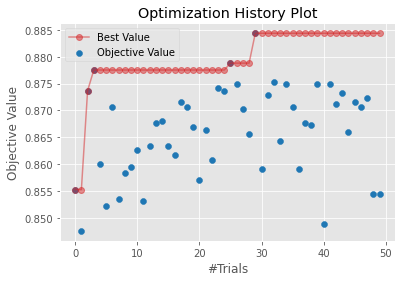

In [45]:
optuna.visualization.matplotlib.plot_optimization_history(cnn_study);

/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_58172/3633289961.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(cnn_study);


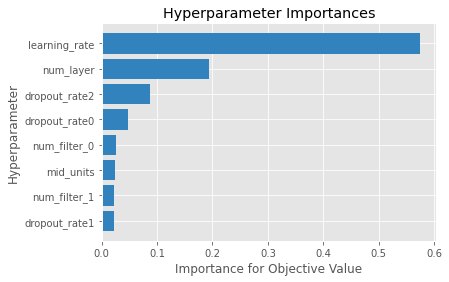

In [46]:
optuna.visualization.matplotlib.plot_param_importances(cnn_study);

/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_58172/3328840784.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(cnn_study);


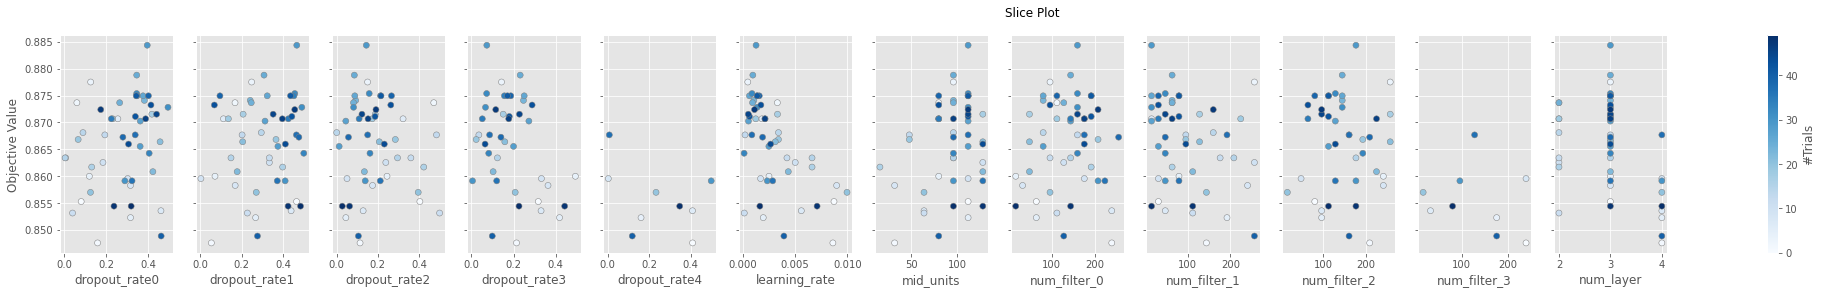

In [47]:
optuna.visualization.matplotlib.plot_slice(cnn_study);

In [50]:
cnn_study.best_params

{'num_layer': 3,
 'mid_units': 112.0,
 'num_filter_0': 160.0,
 'num_filter_1': 16.0,
 'num_filter_2': 176.0,
 'dropout_rate0': 0.39676685105222653,
 'dropout_rate1': 0.465946308365782,
 'dropout_rate2': 0.14435313492491197,
 'dropout_rate3': 0.07275611567529669,
 'learning_rate': 0.0012580904276117198}

In [54]:
cnn_acc = []
cnn_pred = np.zeros((test_x.shape[0], 4))
seed = 42
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)

for i, (train_idx, val_idx) in enumerate(skf.split(train_x, train.target)):
    print(f"{i+1} Fold Training.....")
    x_train, y_train = train_x[train_idx], train_y[train_idx]
    x_val, y_val = train_x[val_idx], train_y[val_idx]
    
    cnn = create_model(cnn_study.best_params['num_layer'], cnn_study.best_params['mid_units'], 
                      [cnn_study.best_params[f'num_filter_{i}'] for i in range(cnn_study.best_params['num_layer'])],
                      [cnn_study.best_params[f'dropout_rate{i}'] for i in range(4)])
    
    # ModelCheckpoint Fold마다 갱신
    mc = ModelCheckpoint(f"model_{i+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
    
    # 모델 Complie
    optimizer = Adam(learning_rate=cnn_study.best_params['learning_rate'])
    cnn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
    cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[es,mc], verbose=0)
    
    # 최고 성능 기록 모델
    best = load_model(f"model_{i+1}.h5")
    
    val_pred = best.predict(x_val)
    
    val_cls = np.argmax(val_pred, axis=1)
    
    fold_cnn_acc = accuracy_score(np.argmax(y_val, axis=1), val_cls)
    cnn_acc.append(fold_cnn_acc)
    print(f"{i+1} Fold ACC of CNN = {fold_cnn_acc}\n")
    
    fold_pred = best.predict(test_x) / skf.n_splits
    cnn_pred += fold_pred

1 Fold Training.....
1 Fold ACC of CNN = 0.8693790149892934

2 Fold Training.....
2 Fold ACC of CNN = 0.8822269807280514

3 Fold Training.....
3 Fold ACC of CNN = 0.867237687366167

4 Fold Training.....
4 Fold ACC of CNN = 0.8693790149892934

5 Fold Training.....
5 Fold ACC of CNN = 0.8865096359743041



In [55]:
np.mean(cnn_acc)

0.8749464668094218

## 5. Submission

In [69]:
pd.read_csv("submission/20220314-3.csv").target.value_counts()

2    2482
1    2414
3    2268
0    2179
Name: target, dtype: int64

In [66]:
pd.read_csv("submission/20220314-2.csv").target.value_counts()

2    2472
1    2412
3    2275
0    2184
Name: target, dtype: int64

In [68]:
submission['target'] = np.argmax(
    lgb_pred * 0.3 +
    cnn_pred * 0.7,
    axis = 1)
submission.to_csv('submission/20220314-3.csv', index = False)
submission.target.value_counts()

2    2482
1    2414
3    2268
0    2179
Name: target, dtype: int64

In [59]:
submission['target'] = np.argmax(
    lgb_pred * 0.1 +
    cnn_pred * 0.9,
    axis = 1)
submission.to_csv('submission/20220314-1.csv', index = False)
submission.target.value_counts()

2    2461
1    2409
3    2282
0    2191
Name: target, dtype: int64